# Similar Movie Poster Retrieval using Neural Networks with and without fine-tuning

### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/


To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Import

In [22]:
import numpy as np
import pandas as pd
import os
from PIL import Image   # for accessing images
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # useful for distances in the embedding

In [23]:
import tensorflow as tf   # opensource machine learning library
from tensorflow import keras
from keras import layers, models

In [24]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

In [25]:
img_array = np.array(images)

In [26]:
img_array.shape

(1238, 268, 182, 3)

In [27]:
# read the csv
df = pd.read_csv("Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [28]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [29]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [30]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [31]:
df4.shape # 1238 rows matches the image data shape above

(1238, 6)

In [32]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]
assert all(np.isfinite(years)) # no missing values in years
print(years.min(), years.max())

1888.0 2016.0


In [33]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')

### Part 1. Create embedding

Here we are using ResNet50 to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and putting all of these together into a single tensor of shape `(n_movies, embedding_size)`.

In [34]:
#importing libraries and layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation, Flatten


n_movies = img_array.shape[0]
embedding_size = 4

X = tf.zeros((n_movies, embedding_size))

# Here, I am implementing ResNet50 because we can use it to add more layers without going into vanishing gradient

base_model = ResNet50(weights='imagenet', 
                 input_shape=img_array[0].shape, 
                 include_top=False)


base_model.trainable = False

#Implementing sequential model of keras
model = models.Sequential([
    base_model,
])
model.add(Flatten())#Flattening to convert it into 1-D 


for i in range(n_movies):
    img = img_array[i]
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

X = model.predict(img_array)

    
print(X.shape)

    
print(len(X.shape) == 2) # X should be (n_movies, embedding_size)
print(X.shape[0] == n_movies)

39/39 [==============================] - 14s 107ms/step
(1238, 110592)
True
True


<b>References</b>
https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4


### Part 2. Define a nearest-neighbour function

`def nearest(img, k)` accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

In [35]:
def k_nearest(img, k):
        
    img = np.expand_dims(img,0)
    img = preprocess_input(img)
    embeddings = model.predict(img)
    distances = cdist(embeddings, X, metric='euclidean')  #Using distance metric as Euclidean
    sorted_movies = np.argsort(distances[0])
    
    
    return sorted_movies[:k]#ranking the movies in the order
    

<b>References</b><br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html<br>
https://numpy.org/doc/stable/reference/generated/numpy.argsort.html<br>

### Part 3: Demonstrate nearest-neighbour function

Here we choose a rando, movie poster. Call this the query poster. Show it, and use our nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself).

1/1 [==============================] - 1s 649ms/step


[666 998 410  17]


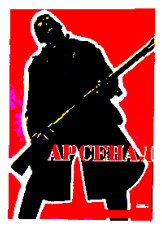

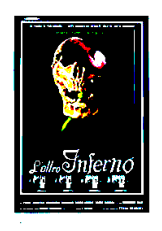

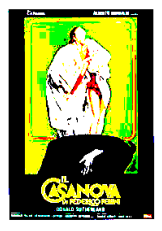

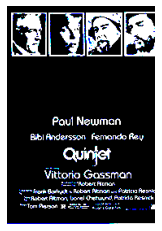

In [36]:
Q_idx = 19649 # YOUR VALUE HERE - DO NOT USE MY VALUE

img = np.array(imread(Q_idx))
result = k_nearest(img, 4)#Calling the k_nearest function from above

print(result)

for i in result: 
    plt.imshow(img_array[i]),plt.axis('off') # show the rotated image
    plt.show()

### Part 4: Year regression

Here, we will attempt to predict the year, given the poster. We will build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. It should be possible to make a prediction, given a new poster (not part of the original dataset). 

In [38]:
#importing libraries
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(img_array, years, 
                                                    shuffle=True, 
                                                    random_state=40, 
                                                    test_size=0.2)

#Adding layers in the model
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


#Compiling the model
model.compile(optimizer='adam',
             loss='mse',
             metrics=['mae'])

# The below will stop the training when there is no improvement in the loss for three consecutive epochs.
es = EarlyStopping(monitor='accuracy', patience=3)

# Data Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

history = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=[es], 
                    validation_data=(X_test,y_test))

score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test means absolute error:', score[1])


Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 2263657.5000 - mae: 1457.4188

31/31 [==============================] - 13s 261ms/step - loss: 2263657.5000 - mae: 1457.4188 - val_loss: 487105.9688 - val_mae: 695.4047
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 91076.0078 - mae: 242.2123

31/31 [==============================] - 4s 140ms/step - loss: 91076.0078 - mae: 242.2123 - val_loss: 20523.5293 - val_mae: 118.3094
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 9501.6680 - mae: 78.0956

31/31 [==============================] - 4s 139ms/step - loss: 9501.6680 - mae: 78.0956 - val_loss: 6698.1270 - val_mae: 64.2629
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 6096.2192 - mae: 62.1755

31/31 [==============================] - 4s 141ms/step - loss: 6096.2192 - mae: 62.1755 - val_loss: 5841.1279 - val_mae: 59.5280
Epoch 5/50
31/31 [==============================] - ETA: 0s - loss: 5510.6006 - mae: 59.0368

31/31 [==============================] - 4s 122ms/step - loss: 5510.6006 - mae: 59.0368 - val_loss: 5235.2373 - val_mae: 56.3588
Epoch 6/50
31/31 [==============================] - ETA: 0s - loss: 4966.9468 - mae: 55.8754

31/31 [==============================] - 4s 139ms/step - loss: 4966.9468 - mae: 55.8754 - val_loss: 4735.8989 - val_mae: 53.5753
Epoch 7/50
31/31 [==============================] - ETA: 0s - loss: 4522.8965 - mae: 53.5112

31/31 [==============================] - 4s 143ms/step - loss: 4522.8965 - mae: 53.5112 - val_loss: 4354.4712 - val_mae: 51.5653
Epoch 8/50
31/31 [==============================] - ETA: 0s - loss: 4079.9897 - mae: 51.0336

31/31 [==============================] - 4s 140ms/step - loss: 4079.9897 - mae: 51.0336 - val_loss: 4061.7734 - val_mae: 49.7136
Epoch 9/50
31/31 [==============================] - ETA: 0s - loss: 3769.8420 - mae: 48.8372

31/31 [==============================] - 4s 140ms/step - loss: 3769.8420 - mae: 48.8372 - val_loss: 3743.6648 - val_mae: 47.8607
Epoch 10/50
31/31 [==============================] - ETA: 0s - loss: 3462.9067 - mae: 46.9823

31/31 [==============================] - 4s 144ms/step - loss: 3462.9067 - mae: 46.9823 - val_loss: 3526.8181 - val_mae: 46.4390
Epoch 11/50
31/31 [==============================] - ETA: 0s - loss: 3204.9534 - mae: 45.1208

31/31 [==============================] - 4s 141ms/step - loss: 3204.9534 - mae: 45.1208 - val_loss: 3359.7456 - val_mae: 45.0986
Epoch 12/50
31/31 [==============================] - ETA: 0s - loss: 2990.8340 - mae: 43.6082

31/31 [==============================] - 4s 141ms/step - loss: 2990.8340 - mae: 43.6082 - val_loss: 3189.3254 - val_mae: 43.9998
Epoch 13/50
31/31 [==============================] - ETA: 0s - loss: 2805.4177 - mae: 42.2408

31/31 [==============================] - 4s 143ms/step - loss: 2805.4177 - mae: 42.2408 - val_loss: 3016.3152 - val_mae: 43.0148
Epoch 14/50
31/31 [==============================] - ETA: 0s - loss: 2641.5984 - mae: 40.9349

31/31 [==============================] - 4s 123ms/step - loss: 2641.5984 - mae: 40.9349 - val_loss: 2900.0032 - val_mae: 42.8794
Epoch 15/50
31/31 [==============================] - ETA: 0s - loss: 2527.2322 - mae: 40.0119

31/31 [==============================] - 4s 141ms/step - loss: 2527.2322 - mae: 40.0119 - val_loss: 2765.8875 - val_mae: 41.4147
Epoch 16/50
31/31 [==============================] - ETA: 0s - loss: 2385.3887 - mae: 38.8950

31/31 [==============================] - 4s 145ms/step - loss: 2385.3887 - mae: 38.8950 - val_loss: 2746.1331 - val_mae: 40.4752
Epoch 17/50
31/31 [==============================] - ETA: 0s - loss: 2279.9697 - mae: 38.0239

31/31 [==============================] - 4s 141ms/step - loss: 2279.9697 - mae: 38.0239 - val_loss: 2599.4646 - val_mae: 39.4972
Epoch 18/50
31/31 [==============================] - ETA: 0s - loss: 2159.4536 - mae: 37.0098

31/31 [==============================] - 4s 142ms/step - loss: 2159.4536 - mae: 37.0098 - val_loss: 2484.7783 - val_mae: 38.9214
Epoch 19/50
31/31 [==============================] - ETA: 0s - loss: 2070.4238 - mae: 36.1022

31/31 [==============================] - 4s 124ms/step - loss: 2070.4238 - mae: 36.1022 - val_loss: 2404.8418 - val_mae: 38.1943
Epoch 20/50
31/31 [==============================] - ETA: 0s - loss: 1970.9368 - mae: 35.3325

31/31 [==============================] - 4s 141ms/step - loss: 1970.9368 - mae: 35.3325 - val_loss: 2385.5725 - val_mae: 37.5130
Epoch 21/50
31/31 [==============================] - ETA: 0s - loss: 1903.7338 - mae: 34.7682

31/31 [==============================] - 4s 143ms/step - loss: 1903.7338 - mae: 34.7682 - val_loss: 2260.4075 - val_mae: 36.8682
Epoch 22/50
31/31 [==============================] - ETA: 0s - loss: 1808.9371 - mae: 33.8073

31/31 [==============================] - 4s 142ms/step - loss: 1808.9371 - mae: 33.8073 - val_loss: 2208.9539 - val_mae: 37.2602
Epoch 23/50
31/31 [==============================] - ETA: 0s - loss: 1794.1733 - mae: 33.9961

31/31 [==============================] - 4s 142ms/step - loss: 1794.1733 - mae: 33.9961 - val_loss: 2123.0925 - val_mae: 35.8190
Epoch 24/50
31/31 [==============================] - ETA: 0s - loss: 1685.2318 - mae: 32.5041

31/31 [==============================] - 4s 129ms/step - loss: 1685.2318 - mae: 32.5041 - val_loss: 2068.5759 - val_mae: 35.2314
Epoch 25/50
31/31 [==============================] - ETA: 0s - loss: 1612.7885 - mae: 31.9504

31/31 [==============================] - 4s 143ms/step - loss: 1612.7885 - mae: 31.9504 - val_loss: 1997.2684 - val_mae: 34.7665
Epoch 26/50
31/31 [==============================] - ETA: 0s - loss: 1557.0961 - mae: 31.3807

31/31 [==============================] - 4s 142ms/step - loss: 1557.0961 - mae: 31.3807 - val_loss: 1943.2131 - val_mae: 34.3286
Epoch 27/50
31/31 [==============================] - ETA: 0s - loss: 1500.7528 - mae: 30.8297

31/31 [==============================] - 4s 146ms/step - loss: 1500.7528 - mae: 30.8297 - val_loss: 1897.5107 - val_mae: 33.7362
Epoch 28/50
31/31 [==============================] - ETA: 0s - loss: 1449.1042 - mae: 30.3363

31/31 [==============================] - 4s 143ms/step - loss: 1449.1042 - mae: 30.3363 - val_loss: 1855.4146 - val_mae: 33.8027
Epoch 29/50
31/31 [==============================] - ETA: 0s - loss: 1405.8516 - mae: 29.7573

31/31 [==============================] - 4s 142ms/step - loss: 1405.8516 - mae: 29.7573 - val_loss: 1810.3906 - val_mae: 32.8820
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 1351.5127 - mae: 29.3478

31/31 [==============================] - 4s 127ms/step - loss: 1351.5127 - mae: 29.3478 - val_loss: 1780.7863 - val_mae: 32.5287
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 1317.9354 - mae: 28.9653

31/31 [==============================] - 4s 142ms/step - loss: 1317.9354 - mae: 28.9653 - val_loss: 1763.1715 - val_mae: 32.3464
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 1261.3588 - mae: 28.3041

31/31 [==============================] - 4s 143ms/step - loss: 1261.3588 - mae: 28.3041 - val_loss: 1682.7151 - val_mae: 31.6426
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 1225.0015 - mae: 27.7927

31/31 [==============================] - 4s 126ms/step - loss: 1225.0015 - mae: 27.7927 - val_loss: 1628.5978 - val_mae: 31.2417
Epoch 34/50
31/31 [==============================] - ETA: 0s - loss: 1181.7896 - mae: 27.1958

31/31 [==============================] - 4s 143ms/step - loss: 1181.7896 - mae: 27.1958 - val_loss: 1600.7050 - val_mae: 30.9012
Epoch 35/50
31/31 [==============================] - ETA: 0s - loss: 1153.3733 - mae: 26.8493

31/31 [==============================] - 4s 128ms/step - loss: 1153.3733 - mae: 26.8493 - val_loss: 1561.6411 - val_mae: 30.5777
Epoch 36/50
31/31 [==============================] - ETA: 0s - loss: 1107.1609 - mae: 26.4681

31/31 [==============================] - 4s 143ms/step - loss: 1107.1609 - mae: 26.4681 - val_loss: 1529.6658 - val_mae: 30.2117
Epoch 37/50
31/31 [==============================] - ETA: 0s - loss: 1074.1337 - mae: 25.9369

31/31 [==============================] - 4s 125ms/step - loss: 1074.1337 - mae: 25.9369 - val_loss: 1493.6970 - val_mae: 29.8331
Epoch 38/50
31/31 [==============================] - ETA: 0s - loss: 1066.2306 - mae: 25.9431

31/31 [==============================] - 4s 128ms/step - loss: 1066.2306 - mae: 25.9431 - val_loss: 1464.3136 - val_mae: 29.5361
Epoch 39/50
31/31 [==============================] - ETA: 0s - loss: 1006.2740 - mae: 25.1413

31/31 [==============================] - 4s 126ms/step - loss: 1006.2740 - mae: 25.1413 - val_loss: 1440.0864 - val_mae: 29.2939
Epoch 40/50
31/31 [==============================] - ETA: 0s - loss: 1001.1019 - mae: 24.9232

31/31 [==============================] - 4s 143ms/step - loss: 1001.1019 - mae: 24.9232 - val_loss: 1465.9916 - val_mae: 29.9178
Epoch 41/50
31/31 [==============================] - ETA: 0s - loss: 960.9474 - mae: 24.5108

31/31 [==============================] - 4s 145ms/step - loss: 960.9474 - mae: 24.5108 - val_loss: 1383.8839 - val_mae: 28.7216
Epoch 42/50
31/31 [==============================] - ETA: 0s - loss: 935.2437 - mae: 24.2728

31/31 [==============================] - 4s 143ms/step - loss: 935.2437 - mae: 24.2728 - val_loss: 1395.8235 - val_mae: 29.1798
Epoch 43/50
31/31 [==============================] - ETA: 0s - loss: 904.3936 - mae: 23.7468

31/31 [==============================] - 4s 144ms/step - loss: 904.3936 - mae: 23.7468 - val_loss: 1353.5995 - val_mae: 28.6588
Epoch 44/50
31/31 [==============================] - ETA: 0s - loss: 883.8222 - mae: 23.3767

31/31 [==============================] - 4s 129ms/step - loss: 883.8222 - mae: 23.3767 - val_loss: 1320.2527 - val_mae: 28.0197
Epoch 45/50
31/31 [==============================] - ETA: 0s - loss: 845.4943 - mae: 22.9392

31/31 [==============================] - 4s 126ms/step - loss: 845.4943 - mae: 22.9392 - val_loss: 1296.1206 - val_mae: 27.8111
Epoch 46/50
31/31 [==============================] - ETA: 0s - loss: 824.5942 - mae: 22.6974

31/31 [==============================] - 4s 126ms/step - loss: 824.5942 - mae: 22.6974 - val_loss: 1280.3130 - val_mae: 27.7628
Epoch 47/50
31/31 [==============================] - ETA: 0s - loss: 803.5751 - mae: 22.3742

31/31 [==============================] - 4s 129ms/step - loss: 803.5751 - mae: 22.3742 - val_loss: 1260.9698 - val_mae: 27.4744
Epoch 48/50
31/31 [==============================] - ETA: 0s - loss: 783.7206 - mae: 22.0685

31/31 [==============================] - 4s 143ms/step - loss: 783.7206 - mae: 22.0685 - val_loss: 1256.2157 - val_mae: 27.3206
Epoch 49/50
31/31 [==============================] - ETA: 0s - loss: 775.5618 - mae: 21.9023

31/31 [==============================] - 4s 127ms/step - loss: 775.5618 - mae: 21.9023 - val_loss: 1234.4183 - val_mae: 27.3933
Epoch 50/50
31/31 [==============================] - ETA: 0s - loss: 739.3569 - mae: 21.4193

8/8 [==============================] - 1s 97ms/step - loss: 1213.9993 - mae: 26.8747
Test loss: 1213.999267578125
Test means absolute error: 26.874731063842773


<b>Explanation</b><br>
The model performed well with the test loss: 1213.999 and mean absolute error:26.874.<br>
We wanted to keep the model simple so just added dense layer with activation='relu'.We used relu activation because it does not activate all neurons at the same time. And reason for using the activation as linear in the last layer is that when we go to the output layer we will be having actual values in that layer instead of some values between some specific range. Furthermore, we have used early-stopping to stop the training when there is no improvement in the training.And we have used patience as the parameter and had given it value as 3 so that if we are not improving and the value is constant for 3 consecutive epochs then the model will stop execution and give us the result. With the results, we can say that the model can predict the year of the poster efficiently.

<b>References</b>
https://keras.io/api/callbacks/early_stopping/<br>
https://www.pluralsight.com/guides/regression-keras<br>
https://www.projectpro.io/recipes/perform-basic-regression-keras-model<br>
https://towardsdatascience.com/a-simple-introduction-to-tensorflow-d992eb2e3dbb<br>

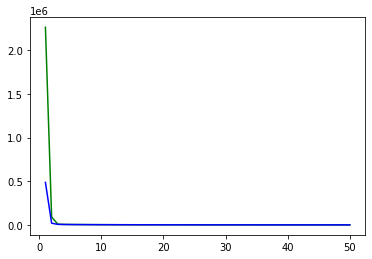

In [42]:
#Visualisation for training and validation loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')



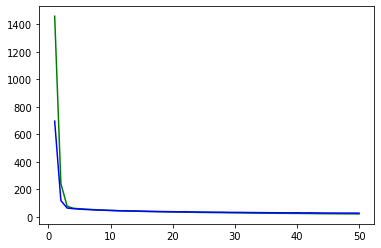

In [43]:
#Visualisation for mean absolute error for training and validation
loss_train = history.history['mae']
loss_val = history.history['val_mae']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('MAE')


### Part 5: Improvements

Now we will fine-tune our model by making the `base_model.trainable = True`.

In [44]:
# Fine Tuning

#Changing model.trainable to true
base_model.trainable = True

#Adding layers to the model 
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='linear'))


#Compiling the model
model.compile(tf.keras.optimizers.RMSprop(
    learning_rate = 0.0001,
    momentum = 0.1,
),
             loss='mse',
             metrics=['mae'])

# The below will stop the training when there is no improvement in the loss for three consecutive epochs.
es = EarlyStopping(monitor='accuracy', patience=3)

# Data Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

history = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=[es], 
                    validation_data=(X_test,y_test))

new_score = model.evaluate(X_test, y_test)
print('Test loss:', new_score[0])
print('Test means absolute error:', new_score[1])


Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 4020952.5000 - mae: 2004.0930

31/31 [==============================] - 46s 461ms/step - loss: 4020952.5000 - mae: 2004.0930 - val_loss: 4458332.5000 - val_mae: 2111.3499
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 3968507.2500 - mae: 1991.9359

31/31 [==============================] - 11s 353ms/step - loss: 3968507.2500 - mae: 1991.9359 - val_loss: 3923629.5000 - val_mae: 1980.6804
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 3947948.0000 - mae: 1986.7257

31/31 [==============================] - 12s 376ms/step - loss: 3947948.0000 - mae: 1986.7257 - val_loss: 3602853.7500 - val_mae: 1897.9775
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 3784842.2500 - mae: 1944.0695

31/31 [==============================] - 11s 363ms/step - loss: 3784842.2500 - mae: 1944.0695 - val_loss: 2388183.5000 - val_mae: 1545.2020
Epoch 5/50
31/31 [==============================] - ETA: 0s - loss: 3192264.2500 - mae: 1776.2604

31/31 [==============================] - 11s 368ms/step - loss: 3192264.2500 - mae: 1776.2604 - val_loss: 1768126.8750 - val_mae: 1329.5084
Epoch 6/50
31/31 [==============================] - ETA: 0s - loss: 2498504.2500 - mae: 1545.0708

31/31 [==============================] - 12s 390ms/step - loss: 2498504.2500 - mae: 1545.0708 - val_loss: 2011856.2500 - val_mae: 1418.2109
Epoch 7/50
31/31 [==============================] - ETA: 0s - loss: 1803157.7500 - mae: 1258.7562

31/31 [==============================] - 12s 390ms/step - loss: 1803157.7500 - mae: 1258.7562 - val_loss: 1102839.2500 - val_mae: 1049.9072
Epoch 8/50
31/31 [==============================] - ETA: 0s - loss: 1262715.5000 - mae: 990.7606

31/31 [==============================] - 12s 386ms/step - loss: 1262715.5000 - mae: 990.7606 - val_loss: 209268.3125 - val_mae: 456.8742
Epoch 9/50
31/31 [==============================] - ETA: 0s - loss: 939241.3750 - mae: 815.2184

31/31 [==============================] - 12s 383ms/step - loss: 939241.3750 - mae: 815.2184 - val_loss: 930466.1875 - val_mae: 964.3298
Epoch 10/50
31/31 [==============================] - ETA: 0s - loss: 908776.8750 - mae: 788.6353

31/31 [==============================] - 11s 367ms/step - loss: 908776.8750 - mae: 788.6353 - val_loss: 1020327.1875 - val_mae: 1009.8480
Epoch 11/50
31/31 [==============================] - ETA: 0s - loss: 777905.8125 - mae: 720.2687

31/31 [==============================] - 12s 384ms/step - loss: 777905.8125 - mae: 720.2687 - val_loss: 447657.2188 - val_mae: 668.6725
Epoch 12/50
31/31 [==============================] - ETA: 0s - loss: 699966.6250 - mae: 688.9349

31/31 [==============================] - 12s 386ms/step - loss: 699966.6250 - mae: 688.9349 - val_loss: 577885.2500 - val_mae: 759.8362
Epoch 13/50
31/31 [==============================] - ETA: 0s - loss: 732133.7500 - mae: 702.8232

31/31 [==============================] - 11s 369ms/step - loss: 732133.7500 - mae: 702.8232 - val_loss: 777148.0000 - val_mae: 881.2569
Epoch 14/50
31/31 [==============================] - ETA: 0s - loss: 703673.5000 - mae: 692.7521

31/31 [==============================] - 12s 386ms/step - loss: 703673.5000 - mae: 692.7521 - val_loss: 563271.3750 - val_mae: 750.1581
Epoch 15/50
31/31 [==============================] - ETA: 0s - loss: 644510.0000 - mae: 656.2898

31/31 [==============================] - 12s 387ms/step - loss: 644510.0000 - mae: 656.2898 - val_loss: 748451.1250 - val_mae: 864.8218
Epoch 16/50
31/31 [==============================] - ETA: 0s - loss: 585427.5625 - mae: 622.5389

31/31 [==============================] - 12s 386ms/step - loss: 585427.5625 - mae: 622.5389 - val_loss: 422049.8125 - val_mae: 649.2422
Epoch 17/50
31/31 [==============================] - ETA: 0s - loss: 630245.1250 - mae: 658.2892

31/31 [==============================] - 11s 368ms/step - loss: 630245.1250 - mae: 658.2892 - val_loss: 225778.1094 - val_mae: 474.5987
Epoch 18/50
31/31 [==============================] - ETA: 0s - loss: 570206.1250 - mae: 621.9573

31/31 [==============================] - 11s 368ms/step - loss: 570206.1250 - mae: 621.9573 - val_loss: 344448.3125 - val_mae: 586.4420
Epoch 19/50
31/31 [==============================] - ETA: 0s - loss: 559961.8125 - mae: 611.1877

31/31 [==============================] - 11s 368ms/step - loss: 559961.8125 - mae: 611.1877 - val_loss: 375027.8125 - val_mae: 611.9588
Epoch 20/50
31/31 [==============================] - ETA: 0s - loss: 555826.3125 - mae: 610.3188

31/31 [==============================] - 12s 384ms/step - loss: 555826.3125 - mae: 610.3188 - val_loss: 354561.2188 - val_mae: 595.0017
Epoch 21/50
31/31 [==============================] - ETA: 0s - loss: 536902.9375 - mae: 604.8942

31/31 [==============================] - 11s 368ms/step - loss: 536902.9375 - mae: 604.8942 - val_loss: 338509.2188 - val_mae: 581.3566
Epoch 22/50
31/31 [==============================] - ETA: 0s - loss: 509471.8750 - mae: 583.4146

31/31 [==============================] - 12s 386ms/step - loss: 509471.8750 - mae: 583.4146 - val_loss: 353906.7812 - val_mae: 594.4515
Epoch 23/50
31/31 [==============================] - ETA: 0s - loss: 473488.0312 - mae: 566.1885

31/31 [==============================] - 12s 385ms/step - loss: 473488.0312 - mae: 566.1885 - val_loss: 144211.6875 - val_mae: 379.0478
Epoch 24/50
31/31 [==============================] - ETA: 0s - loss: 479110.0312 - mae: 560.1316

31/31 [==============================] - 12s 385ms/step - loss: 479110.0312 - mae: 560.1316 - val_loss: 40987.2617 - val_mae: 201.1286
Epoch 25/50
31/31 [==============================] - ETA: 0s - loss: 455114.9062 - mae: 548.2635

31/31 [==============================] - 11s 370ms/step - loss: 455114.9062 - mae: 548.2635 - val_loss: 175540.4531 - val_mae: 418.3373
Epoch 26/50
31/31 [==============================] - ETA: 0s - loss: 458328.9688 - mae: 555.1033

31/31 [==============================] - 12s 384ms/step - loss: 458328.9688 - mae: 555.1033 - val_loss: 220246.6875 - val_mae: 468.7349
Epoch 27/50
31/31 [==============================] - ETA: 0s - loss: 415581.4688 - mae: 524.8206

31/31 [==============================] - 12s 385ms/step - loss: 415581.4688 - mae: 524.8206 - val_loss: 225410.7812 - val_mae: 474.2114
Epoch 28/50
31/31 [==============================] - ETA: 0s - loss: 431009.3438 - mae: 536.6484

31/31 [==============================] - 12s 385ms/step - loss: 431009.3438 - mae: 536.6484 - val_loss: 229586.1250 - val_mae: 478.5936
Epoch 29/50
31/31 [==============================] - ETA: 0s - loss: 407349.5938 - mae: 513.4894

31/31 [==============================] - 12s 385ms/step - loss: 407349.5938 - mae: 513.4894 - val_loss: 258187.3438 - val_mae: 507.5956
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 410012.0625 - mae: 519.5787

31/31 [==============================] - 12s 386ms/step - loss: 410012.0625 - mae: 519.5787 - val_loss: 175246.1250 - val_mae: 417.9859
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 431480.6562 - mae: 537.1284

31/31 [==============================] - 12s 385ms/step - loss: 431480.6562 - mae: 537.1284 - val_loss: 229720.9062 - val_mae: 478.7346
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 400155.0625 - mae: 507.8636

31/31 [==============================] - 12s 386ms/step - loss: 400155.0625 - mae: 507.8636 - val_loss: 154931.8438 - val_mae: 392.9346
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 384292.7812 - mae: 501.6375

31/31 [==============================] - 12s 385ms/step - loss: 384292.7812 - mae: 501.6375 - val_loss: 180895.7188 - val_mae: 424.6898
Epoch 34/50
31/31 [==============================] - ETA: 0s - loss: 369354.3125 - mae: 489.4622

31/31 [==============================] - 12s 385ms/step - loss: 369354.3125 - mae: 489.4622 - val_loss: 164349.9688 - val_mae: 404.7428
Epoch 35/50
31/31 [==============================] - ETA: 0s - loss: 374272.6875 - mae: 499.2898

31/31 [==============================] - 12s 383ms/step - loss: 374272.6875 - mae: 499.2898 - val_loss: 105043.2344 - val_mae: 323.2785
Epoch 36/50
31/31 [==============================] - ETA: 0s - loss: 392270.7812 - mae: 505.4323

31/31 [==============================] - 12s 384ms/step - loss: 392270.7812 - mae: 505.4323 - val_loss: 218432.2188 - val_mae: 466.7956
Epoch 37/50
31/31 [==============================] - ETA: 0s - loss: 378799.3438 - mae: 503.4739

31/31 [==============================] - 12s 383ms/step - loss: 378799.3438 - mae: 503.4739 - val_loss: 84520.9688 - val_mae: 289.8055
Epoch 38/50
31/31 [==============================] - ETA: 0s - loss: 349215.5938 - mae: 478.0935

31/31 [==============================] - 11s 367ms/step - loss: 349215.5938 - mae: 478.0935 - val_loss: 127397.3828 - val_mae: 356.1805
Epoch 39/50
31/31 [==============================] - ETA: 0s - loss: 340636.4375 - mae: 470.3142

31/31 [==============================] - 12s 384ms/step - loss: 340636.4375 - mae: 470.3142 - val_loss: 69368.5078 - val_mae: 262.3592
Epoch 40/50
31/31 [==============================] - ETA: 0s - loss: 329817.6875 - mae: 464.1160

31/31 [==============================] - 12s 383ms/step - loss: 329817.6875 - mae: 464.1160 - val_loss: 129165.0234 - val_mae: 358.6466
Epoch 41/50
31/31 [==============================] - ETA: 0s - loss: 326582.9688 - mae: 464.9326

31/31 [==============================] - 12s 384ms/step - loss: 326582.9688 - mae: 464.9326 - val_loss: 158249.5781 - val_mae: 397.1340
Epoch 42/50
31/31 [==============================] - ETA: 0s - loss: 342427.7812 - mae: 469.8493

31/31 [==============================] - 12s 383ms/step - loss: 342427.7812 - mae: 469.8493 - val_loss: 96418.6953 - val_mae: 309.6545
Epoch 43/50
31/31 [==============================] - ETA: 0s - loss: 341173.1562 - mae: 471.5871

31/31 [==============================] - 12s 383ms/step - loss: 341173.1562 - mae: 471.5871 - val_loss: 22090.5566 - val_mae: 146.8268
Epoch 44/50
31/31 [==============================] - ETA: 0s - loss: 342665.1250 - mae: 475.2954

31/31 [==============================] - 12s 384ms/step - loss: 342665.1250 - mae: 475.2954 - val_loss: 113977.6484 - val_mae: 336.8206
Epoch 45/50
31/31 [==============================] - ETA: 0s - loss: 338363.8750 - mae: 473.3852

31/31 [==============================] - 12s 386ms/step - loss: 338363.8750 - mae: 473.3852 - val_loss: 28484.5801 - val_mae: 167.1938
Epoch 46/50
31/31 [==============================] - ETA: 0s - loss: 330282.3438 - mae: 462.6809

31/31 [==============================] - 12s 385ms/step - loss: 330282.3438 - mae: 462.6809 - val_loss: 137642.6406 - val_mae: 370.2836
Epoch 47/50
31/31 [==============================] - ETA: 0s - loss: 309899.8750 - mae: 451.0557

31/31 [==============================] - 11s 370ms/step - loss: 309899.8750 - mae: 451.0557 - val_loss: 55869.9961 - val_mae: 235.2259
Epoch 48/50
31/31 [==============================] - ETA: 0s - loss: 349928.0938 - mae: 481.6690

31/31 [==============================] - 11s 371ms/step - loss: 349928.0938 - mae: 481.6690 - val_loss: 48142.4258 - val_mae: 218.2018
Epoch 49/50
31/31 [==============================] - ETA: 0s - loss: 304422.7812 - mae: 449.0224

31/31 [==============================] - 12s 385ms/step - loss: 304422.7812 - mae: 449.0224 - val_loss: 87296.1875 - val_mae: 294.5941
Epoch 50/50
31/31 [==============================] - ETA: 0s - loss: 326269.1562 - mae: 460.6003

8/8 [==============================] - 1s 102ms/step - loss: 19331.8984 - mae: 137.1703
Test loss: 19331.8984375
Test means absolute error: 137.17025756835938


Text(0, 0.5, 'Loss')

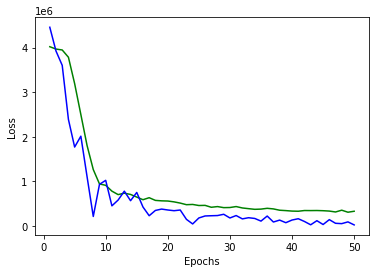

In [45]:
#Visualisation for training and validation loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


Text(0, 0.5, 'MAE')

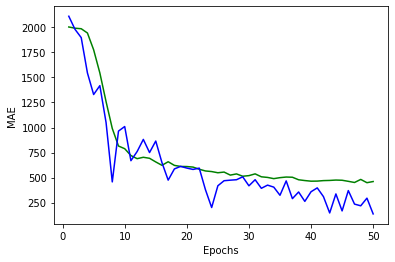

In [46]:
#Visualisation for mean absolute error for training and validation
loss_train = history.history['mae']
loss_val = history.history['val_mae']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('MAE')


After fine-tuning it was seen that the model faced a little bit of overfitting. The reason can be the dataset being the quality of dataset. Sometimes using multiple layers in an NN model can result in overfitting the model. Instead, our first model where we used only single layer worked well for this data.

<b>References</b>
https://keras.io/guides/transfer_learning/